In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa
from sklearn.metrics import classification_report
from librosa import display
from keras import backend as K

2022-11-08 16:41:01.032168: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def plotLabels_(labels, axis, idx, duration, Fs):
    axis.stem(labels)
    axis.set(title='gt: %.1f s to %.1f s and samples: %.1f to %.1f'%(idx*duration, (idx+1)*duration, idx*duration*Fs, (idx+1)*duration*Fs))
    return axis

def plotData(labels, channel_mic, channel_acc, idx, r=3):
    Fs = 24000
    duration = 4
    fig, axis = plt.subplots(nrows=r, ncols=1, figsize=(15,8), sharex=True)
    librosa.display.specshow(channel_acc[idx], cmap = 'RdBu', y_axis='linear', sr=1, hop_length=1, x_axis='frames', ax=axis[0])
    axis[0].set(title='acc data')
    axis[0].label_outer()

    axis[1] = plotLabels_(labels[idx], axis[1], idx, duration, Fs)
    axis[1].set_title('Ground Truth')
    axis[1].label_outer()
    
    librosa.display.specshow(channel_mic[idx], cmap = 'RdBu', y_axis='linear', sr=1, hop_length=1, x_axis='frames', ax=axis[2])
    axis[2].set(title='mic data')
    axis[2].label_outer()
    return fig, axis

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')

In [4]:
# You need the following for testing these out

X_acc = np.load('../data/embeddings/balanced_acc_spectrograms_.npy', allow_pickle=True)
X = np.load('../data/embeddings/balanced_mic_spectrograms_.npy', allow_pickle=True)
Y = np.load('../data/embeddings/balanced_labels_.npy', allow_pickle=True)

In [5]:
X.shape, Y.shape, X_acc.shape

((1937, 257, 375), (1937, 375), (1937, 257, 375))

In [6]:
#zero mean and unit variance normalization
def normalizeXX(eg_array):
    normed = (eg_array - eg_array.mean(axis=0)) / eg_array.std(axis=0)
    return normed

1519


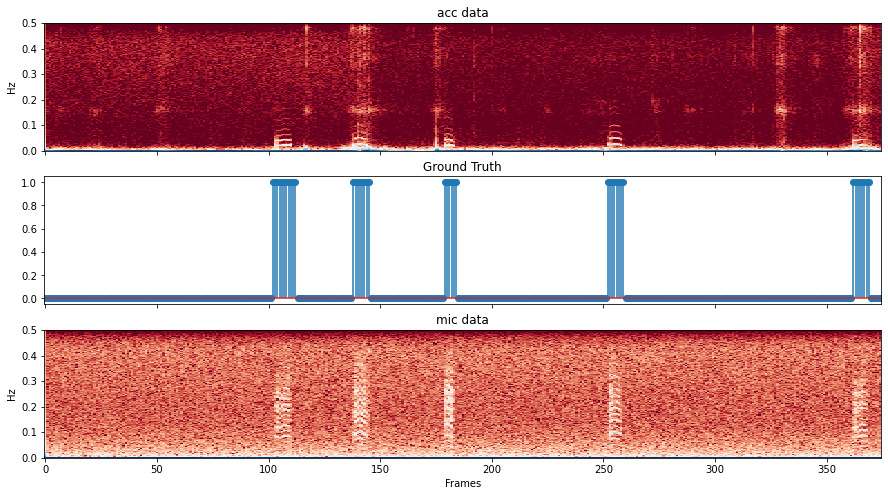

In [7]:
i = np.random.randint(len(X), size=1)
print(i[0])
fig, axis = plotData(Y, X, X_acc, 667)
fig.show()

In [ ]:
dcca_model = tf.keras.models.load_model('../models/dcca_with_binning.h5', compile=False)

In [9]:
model = tf.keras.models.load_model('../models/CRNN_cls_dcca_83.h5', compile=False)

In [10]:
import keras_metrics
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[
              keras.metrics.Precision(), keras.metrics.Recall()], sample_weight_mode="temporal")

In [11]:
X[668]

array([[ -6.22561842,  -0.17776686,  -0.23661994, ...,  -0.29863362,
         -0.27737211,  -0.20977673],
       [ -8.07847695,  -6.15660387,  -6.26518175, ...,  -6.3326311 ,
         -6.29175017,  -6.19251355],
       [-13.75150476, -49.85234464, -56.74985719, ..., -52.43196957,
        -55.11135977, -48.98154005],
       ...,
       [-54.18923931, -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ],
       [-54.21636273, -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ],
       [-54.22102678, -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ]], dtype=float128)

In [12]:
# in_ = np.transpose(np.expand_dims(X[668], 0), (0, 2, 1))
in_ = np.transpose(X, (0, 2, 1))
emb = dcca_model.predict([in_, in_])

2022-11-08 16:41:37.311618: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


 6/61 [=>............................] - ETA: 0s  

2022-11-08 16:41:38.047473: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


61/61 [==============================] - 3s 11ms/step


In [13]:
e = emb[:, :, 0:50]
e.shape

(1937, 375, 50)

In [14]:
e[668, :, :]

array([[0.        , 0.        , 1.8164785 , ..., 0.        , 0.        ,
        0.        ],
       [1.0814899 , 0.        , 0.        , ..., 0.        , 2.529584  ,
        0.        ],
       [0.25831777, 0.        , 0.        , ..., 0.        , 1.7852542 ,
        0.        ],
       ...,
       [1.7869877 , 0.        , 0.        , ..., 0.        , 1.1327034 ,
        0.        ],
       [1.8782579 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.19710855]], dtype=float32)

In [15]:
in_model = np.expand_dims(np.transpose(e, (0, 2, 1)), -1)
y = model.predict(in_model)

2022-11-08 16:41:40.731771: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


61/61 [==============================] - 11s 179ms/step


In [16]:
in_model.shape

(1937, 50, 375, 1)

In [17]:
# model.evaluate(in_model, np.expand_dims(Y[668], 0))
model.evaluate(in_model, Y)

61/61 [==============================] - 13s 199ms/step - loss: 0.2220 - precision: 0.9738 - recall: 0.7152


[0.2220352739095688, 0.9738196730613708, 0.7151678800582886]

In [18]:
y = np.squeeze(y)
y.shape

(1937, 375)

In [19]:
confidence = 0.2 #! Not implemented while actual submission
outcome = np.where(y<confidence, np.zeros(y.shape), np.ones(y.shape))
print(classification_report(Y, outcome))

              precision    recall  f1-score   support

           0       0.73      0.63      0.67       389
           1       0.74      0.63      0.68       387
           2       0.83      0.62      0.71       419
           3       0.90      0.69      0.78       426
           4       0.85      0.66      0.74       435
           5       0.88      0.67      0.76       430
           6       0.93      0.69      0.79       402
           7       0.88      0.74      0.80       346
           8       0.91      0.75      0.82       373
           9       0.93      0.65      0.76       460
          10       0.93      0.74      0.82       457
          11       0.88      0.70      0.78       450
          12       0.82      0.68      0.74       399
          13       0.91      0.74      0.82       389
          14       0.93      0.75      0.83       451
          15       0.89      0.74      0.81       458
          16       0.84      0.68      0.75       464
          17       0.88    

/hdd_storage/users/sumitk/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


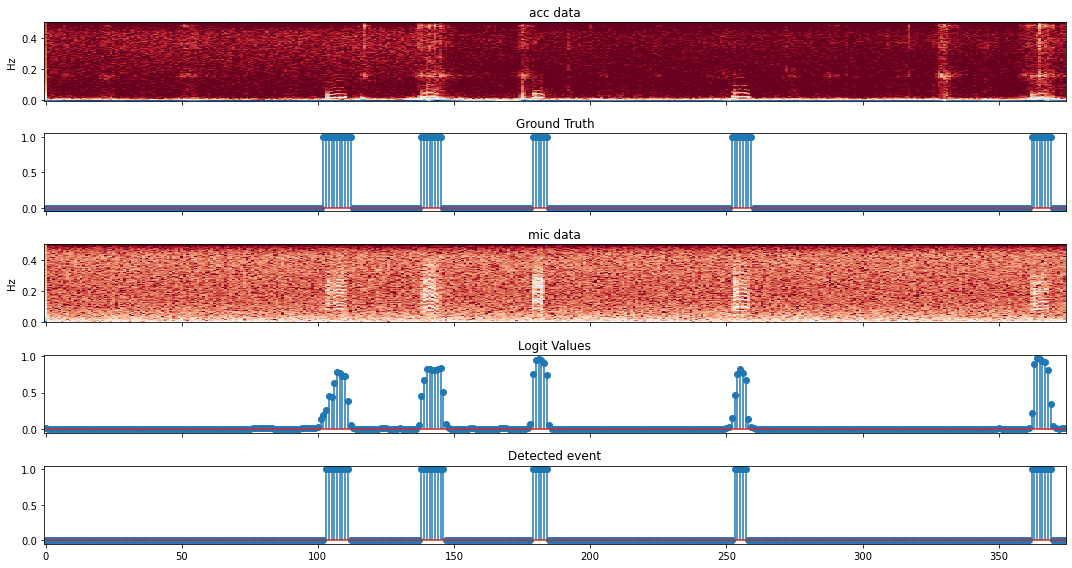

In [22]:
spec_number = 667

fig, axis = plotData(Y, X, X_acc, spec_number, r=5)
axis[3].stem(y[spec_number])
axis[3].set_title('Logit Values')
axis[4].stem(outcome[spec_number])
axis[4].set_title('Detected event')
fig.tight_layout()
fig.show()